In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
all_animes_df = pd.read_csv('./work/data/processed-metadata.csv')

all_animes = []
anime_title_by_id = {}
anime_id_by_title = {}
anime_ix_by_id = {}
anime_by_id = {}

i = 0
for anime in all_animes_df.itertuples(index=False):
    all_animes.append(anime)
    anime_title_by_id[anime.id] = anime.title
    anime_id_by_title[anime.title] = anime.id
    anime_ix_by_id[anime.id] = i
    anime_by_id[anime.id] = anime
    i += 1

In [3]:
all_ratings = pd.read_csv('./work/data/collected_animelists.csv')

In [4]:
# only retain the "username", "anime_id", and "my_score" columns
ratings = all_ratings[['username', 'anime_id', 'my_score']]
del all_ratings
# only retain rows where "my_score" is not null and greater than or equal to 6
ratings = ratings[ratings['my_score'].notnull()]
ratings = ratings[ratings['my_score'] > 5]
ratings = ratings[ratings['anime_id'].isin(anime_title_by_id.keys())]
ratings['anime_ix'] = ratings['anime_id'].apply(lambda x: anime_ix_by_id[x])

def scale_rating(rating: int) -> float:
        if rating == 10:
            return 10
        if rating == 9:
            return 9.1
        if rating == 8:
            return 6.5
        if rating == 7:
            return 3.3
        if rating == 6:
            return 0.5
        if rating == 5:
            return -1.5
        if rating == 4:
            return -4.5
        if rating == 3:
            return -7.5
        if rating == 2:
            return -9.5
        if rating == 1:
            return -10
        raise ValueError("Invalid rating: {}".format(rating))

# scale ratings from score to our custom scale
ratings['my_score'] = ratings['my_score'].apply(lambda score: scale_rating(score) / 10)

print("Retained ratings:", ratings.shape[0])

# collect python garbage
import gc
gc.collect()

Retained ratings: 66596570


13

In [14]:
ratings_subset = ratings.head(25000000)

# Retain only ratings of anime that have >=100 ratings
ratings_subset = ratings_subset[ratings['anime_id'].isin(anime_title_by_id.keys())]
print(f"Retained {ratings_subset.shape[0]} ratings out of {ratings.shape[0]} total")

/tmp/ipykernel_51223/3779104410.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratings_subset = ratings_subset[ratings['anime_id'].isin(anime_title_by_id.keys())]


Retained 25000000 ratings out of 66596570 total


In [15]:
all_users = list(ratings_subset['username'].unique())
user_ix_by_username = {}
for i, username in enumerate(all_users):
    user_ix_by_username[username] = i

user_count = len(all_users)
print("Retained users:", user_count)

Retained users: 128012


In [16]:
ratings_subset['user_ix'] = ratings_subset['username'].apply(lambda x: user_ix_by_username[x])
ratings_subset['anime_ix'] = ratings_subset['anime_id'].apply(lambda x: anime_ix_by_id[x])

In [17]:
# Much of the following code is adapted from here:
# https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb

def build_rating_sparse_tensor(ratings_df):
    indices = ratings_df[['user_ix', 'anime_ix']].values
    values = ratings_df['my_score'].values
    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[user_count, len(all_animes)]
    )

def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    """
    Args:
        sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
        user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
        dimension, such that U_i is the embedding of user i.
        movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
        dimension, such that V_j is the embedding of movie j.
    Returns:
        A scalar Tensor representing the MSE between the true ratings and the
        model's predictions.
    """
    predictions = tf.reduce_sum(
        input_tensor=tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
        axis=1
    )
    loss = tf.compat.v1.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

In [18]:
import matplotlib.pyplot as plt

class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.compat.v1.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.compat.v1.variables_initializer(opt.variables()),
          tf.compat.v1.local_variables_initializer()
    )
      if self._session is None:
        self._session = tf.compat.v1.Session()
        with self._session.as_default():
          self._session.run(tf.compat.v1.global_variables_initializer())
          self._session.run(tf.compat.v1.tables_initializer())
          tf.compat.v1.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [19]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

 iteration 1000: train_error=0.572171, test_error=0.606887

[{'train_error': 0.57217103, 'test_error': 0.6068866}]

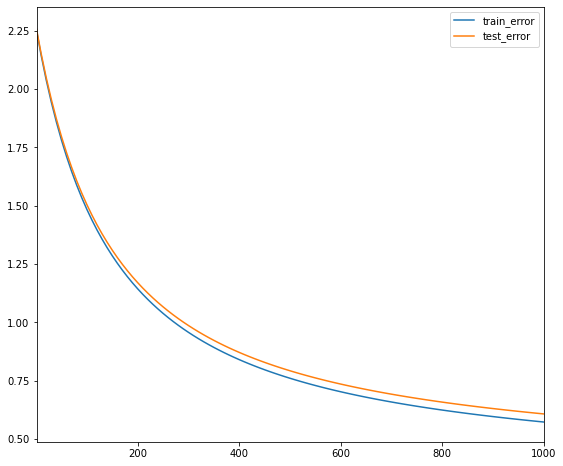

In [26]:
tf.compat.v1.disable_eager_execution()
model = build_model(ratings_subset, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

In [35]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0]*V.shape[0]) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1, init_U=None, init_V=None):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev)) if init_U is None else tf.Variable(init_U)
  V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev)) if init_V is None else tf.Variable(init_V)

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "movie_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

In [43]:
init_U = reg_model.embeddings["user_id"]
init_V = reg_model.embeddings["movie_id"]

backup_U = init_U.copy()
backup_V = init_V.copy()

# save numpy ndarray backups to file
np.save('./work/data/backup_U.npy', backup_U)
np.save('./work/data/backup_V.npy', backup_V)

 iteration 500: train_error_observed=0.172444, test_error_observed=0.173075, observed_loss=0.172444, regularization_loss=0.077150, gravity_loss=0.008797

[{'train_error_observed': 0.17244428, 'test_error_observed': 0.17307477},
 {'observed_loss': 0.17244428,
  'regularization_loss': 0.07714996,
  'gravity_loss': 0.008796804}]

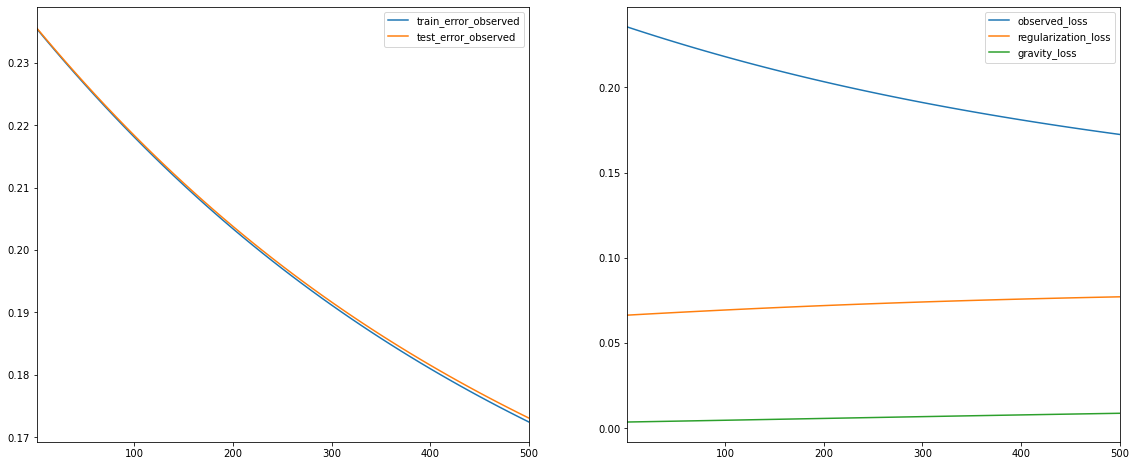

In [38]:
tf.compat.v1.disable_eager_execution()
reg_model = build_regularized_model(
    ratings_subset, regularization_coeff=0.15, gravity_coeff=1.0, embedding_dim=120,
    init_stddev=0.05, init_U=init_U, init_V=init_V
)
reg_model.train(num_iterations=500, learning_rate=20.)

In [39]:
from IPython.display import display

DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

def user_recommendations(model, user_ix: int, measure=DOT, exclude_rated=False, k=6):
    scores = compute_scores(
        model.embeddings["user_id"][user_ix], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'title': all_animes_df['title'],
        'anime_ix': all_animes_df.index
    })
    username = all_users[user_ix]
    print('User:', username)

    if exclude_rated:
        # remove animes that are already rated
        rated_animes = ratings_subset[ratings_subset['user_ix'] == user_ix]['anime_ix'].values
        df = df[df.anime_ix.apply(lambda anime_ix: anime_ix not in rated_animes)]

    display(df.sort_values([score_key], ascending=False).head(k))  

In [42]:
user_recommendations(reg_model, 10822, exclude_rated=False, measure=COSINE, k=20)

User: BlueEstWolf


,cosine score,title,anime_ix
8877,0.304912,"Wei, Kanjian Erduo La! 2",8877
5963,0.294036,3-D Heaven,5963
9714,0.293535,Crayon Shin-chan Movie 29: Mystery Meki! Hana ...,9714
8727,0.292147,Ken to Mahou no Logres: Inishie no Megami x Fa...,8727
151,0.286114,Ultra Maniac,151
5796,0.284228,Ponsuke no Haru,5796
8108,0.270944,Ling Yu 3rd Season,8108
386,0.266124,Legend of Lemnear: Kyokuguro no Tsubasa Valkisas,386
2886,0.266052,.hack//G.U. Trilogy: Parody Mode,2886
446,0.264954,Doraemon,446
